### Comparing single-detector posteriors for GW231123, zero noise and Gaussian noise simulations

(Figure 9)

In [1]:
import bilby
import matplotlib.pyplot as plt
import glob
import numpy as np
import h5py
import pandas as pd
from pesummary.utils.samples_dict import MultiAnalysisSamplesDict
from scipy import stats
from scipy.stats import gaussian_kde
from pesummary.utils.bounded_2d_kde import Bounded_2d_kde
from pesummary.utils.bounded_1d_kde import bounded_1d_kde
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import matplotlib.ticker as ticker
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
matplotlib.rcParams.update({'font.size': 17})
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 20
import matplotlib.collections as mcoll
import matplotlib.lines as mlines
from scipy.spatial.distance import jensenshannon
from matplotlib.lines import Line2D

import config
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["BILBY_INCLUDE_GLOBAL_META_DATA"] = "1"

/home/pe.o4/GWTC4-fogg/environment/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/pe.o4/GWTC4-fogg/environment/lib/python3.10/site-packages/pesummary/gw/plots/plot.py:21: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import MSUN_SI, PC_SI, CreateDict


In [2]:
#define JS 
def js_divergence_scipy(x1, x2, bins=100):
    # Shared bin range
    xmin = min(x1.min(), x2.min())
    xmax = max(x1.max(), x2.max())
    x_grid = np.linspace(xmin, xmax, bins)

    # KDE for both distributions
    kde1 = gaussian_kde(x1)
    kde2 = gaussian_kde(x2)
    p = kde1(x_grid)
    q = kde2(x_grid)

    # Normalize to turn into probability mass
    p /= p.sum()
    q /= q.sum()

    # Compute JS divergence between p and q
    js = jensenshannon(p, q, base=2)#np.e) #base np.e to match pesummary
    return js * js


### Load Gaussian noise simulations single-detector samples

In [3]:
result_files = {}

result_files['L1'] = glob.glob(f"/home/krzysztof.krol/GW231123/PE/injections/maxL/outdir_L1_nrsur/final_result/maxL_injection_L1_nrsur_inference_data*_1384782888-634277_analysis_L1_result.hdf5")
result_files['H1'] = glob.glob(f"/home/krzysztof.krol/GW231123/PE/injections/maxL/outdir_H1_nrsur/final_result/maxL_injection_H1_nrsur_inference_data*_1384782888-634277_analysis_H1_result.hdf5")

results = dict()
for wf in result_files:
    results[wf] = {}
    for file in result_files[wf]:
        run = file.split("_data")[1].split("_1384782888")[0]
        results[wf][run] = bilby.result.read_in_result(file)
        
in_both = set(results['H1'].keys()).intersection(results['L1'].keys())
in_both = sorted(in_both, key=int)
print(len(in_both))
print(in_both)

20
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


Sanity check: check individual posteriors, likelihood, to see if there are bimodalities in parameters...

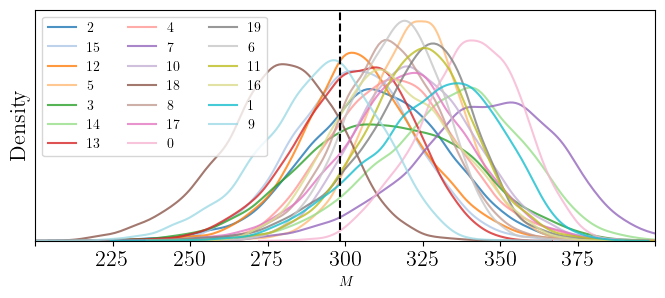

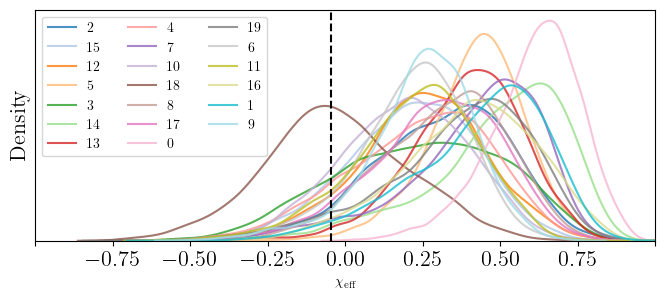

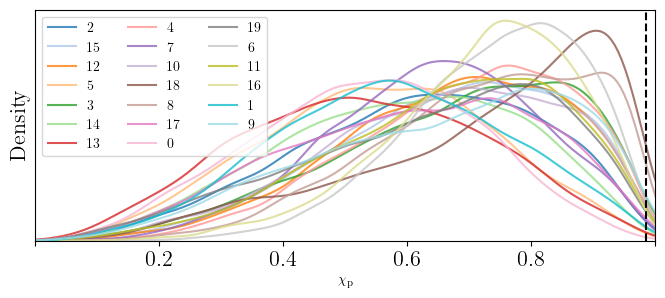

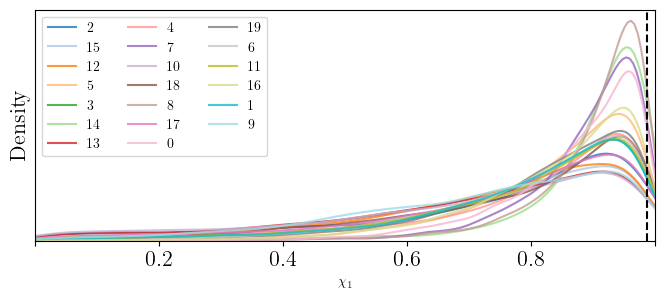

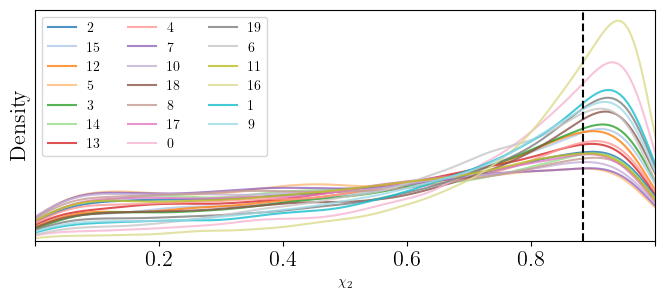

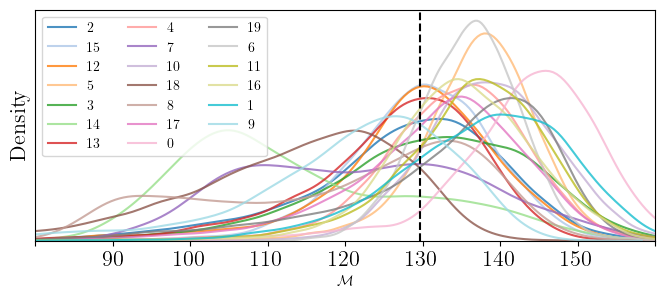

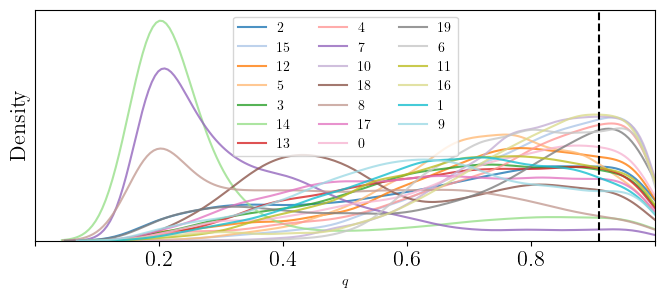

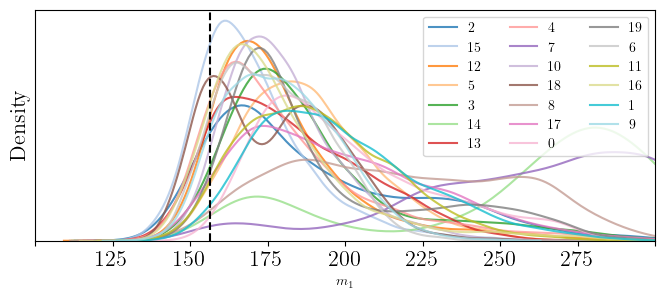

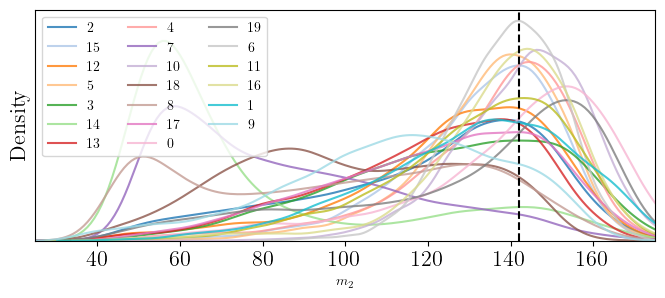

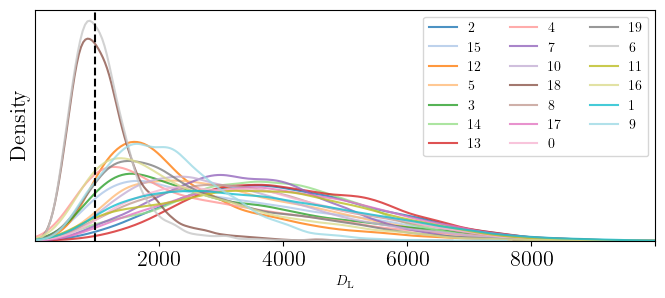

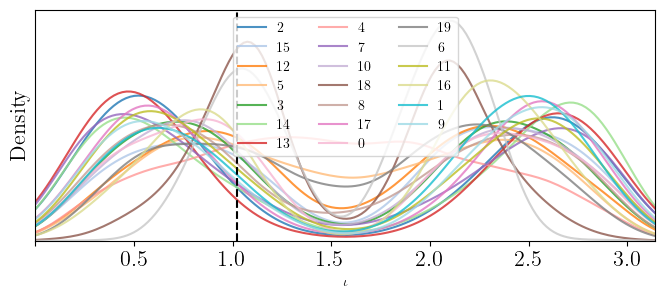

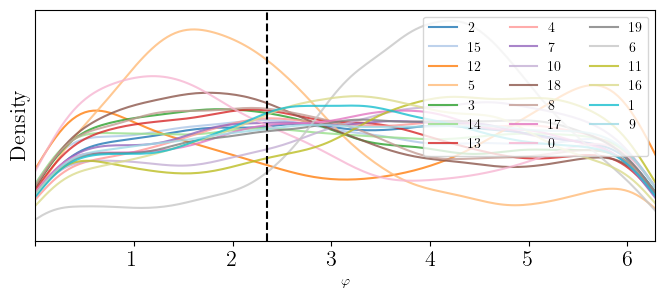

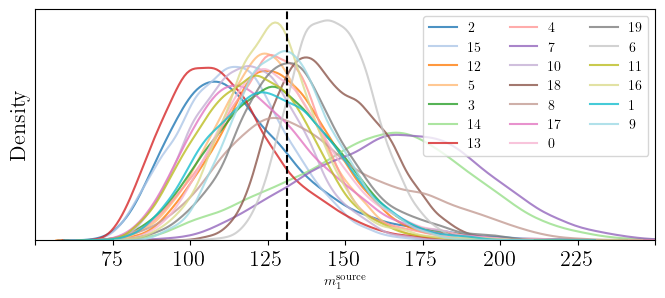

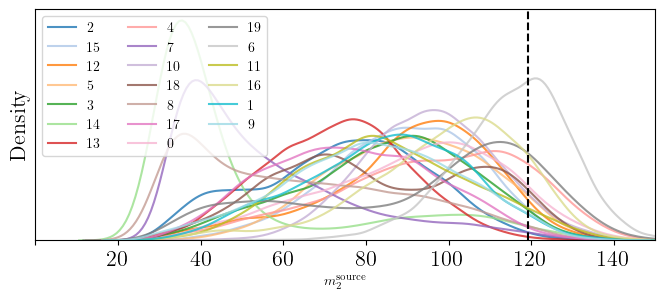

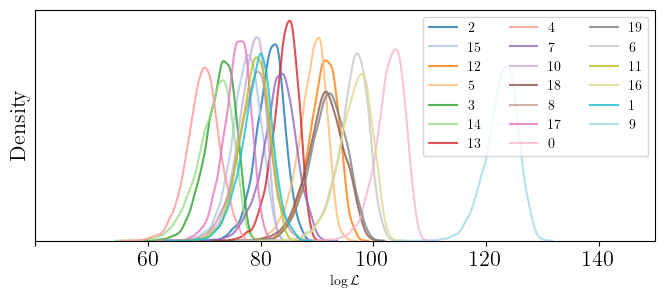

In [11]:
params = ['total_mass', 'chi_eff', 'chi_p', 'a_1', 'a_2', 'chirp_mass', 'mass_ratio', 'mass_1', 'mass_2', 'luminosity_distance', 'iota', 'phase', 'mass_1_source', 'mass_2_source','log_likelihood']
lims = {'total_mass':(200, 400), 'mass_1':(100,300), 'mass_2':(25,175), 'chi_eff':(-1,1), 'chi_p':(0,1), 'mass_ratio':(0,1), 'luminosity_distance':(1,10000), 'iota':(0,3.14152), 'a_1':(0,1), 'a_2':(0,1), 'phase':(0,2*np.pi), 'chirp_mass':(80, 160), 'mass_1_source':(50, 250), 'mass_2_source':(0,150),'log_likelihood':(40,150)}
param_to_str = {'total_mass':r'$M$', 'mass_1':r'$m_1$', 'mass_2':r'$m_2$', 'chi_eff':r'$\chi_{\rm{eff}}$', 'chi_p':r'$\chi_{\rm{p}}$', 'mass_ratio':r'$q$', 'luminosity_distance':r'$D_{\rm{L}}$', 'iota':r'$\iota$', 'a_1':r'$\chi_1$', 'a_2':r'$\chi_2$', 'phase':r'$\varphi$', 'chirp_mass':r'$\mathcal{M}$', 'mass_1_source':r'$m_1^{\rm{source}}$', 'mass_2_source':r'$m_2^{\rm{source}}$', 'log_likelihood':r'$\log \mathcal{L}$'}

extreme=False
fractions = {}
cmap = plt.cm.tab20  # or tab10
colors = cmap.colors
for param in params:
    fig, axes = plt.subplots(1, 1, figsize=(8, 3))
    fig.subplots_adjust(wspace=0)
    
    # Posteriors
    #for wf in results:
    wf ='H1' #one at the time
    colors = [cmap(j % cmap.N) for j in range(20)]

    if extreme:
            lowest = None
            low_seed = None
            low_median = None
            highest = None
            high_seed = None
            high_median = None
            for run in results[wf]:
                if low_median is None or np.median(results[wf][run].posterior[param]) < low_median:
                    low_median = np.median(results[wf][run].posterior[param])
                    lowest = results[wf][run].posterior[param]
                if high_median is None or np.median(results[wf][run].posterior[param]) > high_median:
                    high_median = np.median(results[wf][run].posterior[param])
                    highest = results[wf][run].posterior[param]
            axes.hist(lowest, density=True, color=colors[wf], bins=80, histtype='step')
            axes.hist(highest, density=True, color=colors[wf], bins=80, histtype='step')
            axes.set_title(f"low={low_seed}, high={high_seed}")
    else:
            for j, run in enumerate(results[wf]):
                sns.kdeplot(results[wf][run].posterior, x=param, color=colors[j % len(colors)], alpha=0.8,label=f'{run}')

    if param !='log_likelihood':
        axes.axvline(results[wf][run].injection_parameters[param], color='k', ls='--')
    axes.legend(ncols=3, fontsize=10)         
    axes.set_xlim(lims[param][0], lims[param][1])
    axes.set_xlabel(f"{param_to_str[param]}", fontsize=10)
    axes.set_ylabel('Density', fontsize=16)
    axes.set_yticks([])
    axes.get_xticklabels()[0].set_visible(False)
    axes.get_xticklabels()[-1].set_visible(False)

### Load posteriors for GW231123 event, and zero-noise simulation and compute JS

In [5]:
event = {}
event['H1'] = bilby.read_in_result(config.H_only_NRSUR)
event['L1'] = bilby.read_in_result(config.L_only_NRSUR)

In [6]:
zero_noise = {}
zero_noise['H1'] = bilby.read_in_result("/home/sophie.bini/project/PE/S231123_maxL_0noise/outdir_H1_nrsur/final_result/maxL_injection_H1_nrsur_data0_1384782888-634277_analysis_H1_result.hdf5")
zero_noise['L1'] = bilby.read_in_result("/home/sophie.bini/project/PE/S231123_maxL_0noise/outdir_L1_nrsur/final_result/maxL_injection_L1_nrsur_data0_1384782888-634277_analysis_L1_result.hdf5")

In [7]:
#Compute JS divergences

params = ['total_mass', 'chi_eff', 'chi_p', 'a_1', 'a_2', 'chirp_mass', 'mass_ratio', 'luminosity_distance', 'iota', 'mass_1_source', 'mass_2_source']

print("Beginning divergences for simulatons")
divergences = {}
for param in params:
    print(f"Beginning calculations for {param}")
    divs = []
    for run1 in results['H1']:
        #print(f"Run {run1}")
        for run2 in results['L1']:
            divs.append(js_divergence_scipy(results['H1'][run1].posterior[param], results['L1'][run2].posterior[param]))
    divergences[param] = np.array(divs)
print("Done!")

Beginning divergences for simulatons
Beginning calculations for total_mass
Beginning calculations for chi_eff
Beginning calculations for chi_p
Beginning calculations for a_1
Beginning calculations for a_2
Beginning calculations for chirp_mass
Beginning calculations for mass_ratio
Beginning calculations for luminosity_distance
Beginning calculations for iota
Beginning calculations for mass_1_source
Beginning calculations for mass_2_source
Done!


In [8]:
params = ['total_mass', 'chi_eff', 'chi_p', 'a_1', 'a_2', 'chirp_mass', 'mass_ratio', 'luminosity_distance', 'theta_jn', 'mass_1_source', 'mass_2_source']
print("Beginning divergences for event")
divergences_event = {}
for param in params:
    divs = []        
    divs.append(js_divergence_scipy(event['H1'].posterior[param], event['L1'].posterior[param]))
    divergences_event[param] = np.array(divs)
print("Done!")
divergences_event

Beginning divergences for event
Done!


{'total_mass': array([0.28502025]),
 'chi_eff': array([0.27513958]),
 'chi_p': array([0.23894637]),
 'a_1': array([0.00265188]),
 'a_2': array([0.05775371]),
 'chirp_mass': array([0.16321646]),
 'mass_ratio': array([0.16525445]),
 'luminosity_distance': array([0.73472639]),
 'theta_jn': array([0.73493341]),
 'mass_1_source': array([0.34631848]),
 'mass_2_source': array([0.569372])}

In [9]:
params = ['total_mass', 'chi_eff', 'chi_p', 'a_1', 'a_2', 'chirp_mass', 'mass_ratio', 'luminosity_distance', 'iota', 'mass_1_source', 'mass_2_source']
print("Beginning divergences for zero noise")
divergences_zeronoise = {}
for param in params:
    divs = []        
    divs.append(js_divergence_scipy(zero_noise['H1'].posterior[param], zero_noise['L1'].posterior[param]))
    divergences_zeronoise[param] = np.array(divs)
print("Done!")
divergences_zeronoise

Beginning divergences for zero noise
Done!


{'total_mass': array([0.17754908]),
 'chi_eff': array([0.17285287]),
 'chi_p': array([0.07743383]),
 'a_1': array([0.00939744]),
 'a_2': array([0.00415283]),
 'chirp_mass': array([0.11038923]),
 'mass_ratio': array([0.09107706]),
 'luminosity_distance': array([0.46859721]),
 'iota': array([0.27551835]),
 'mass_1_source': array([0.25098618]),
 'mass_2_source': array([0.31500558])}

### plot in the paper

total_mass: 182 / 400
[0.28502025]


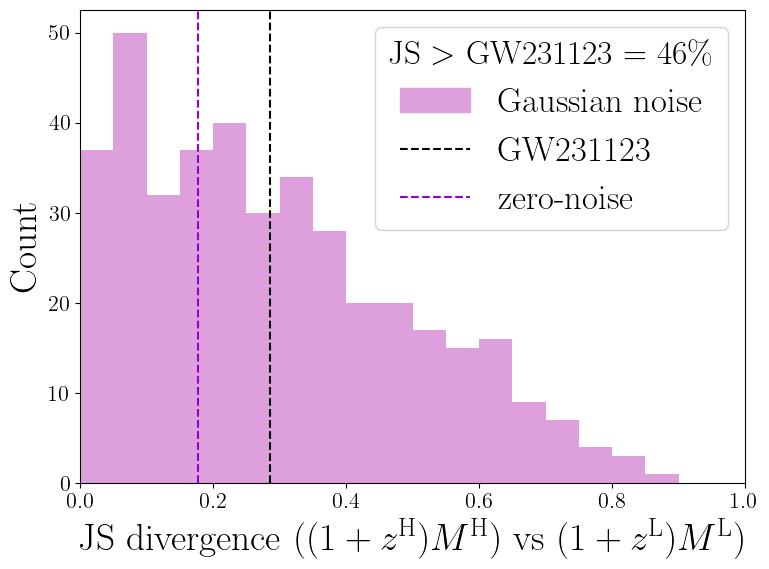

mass_ratio: 163 / 400
[0.16525445]


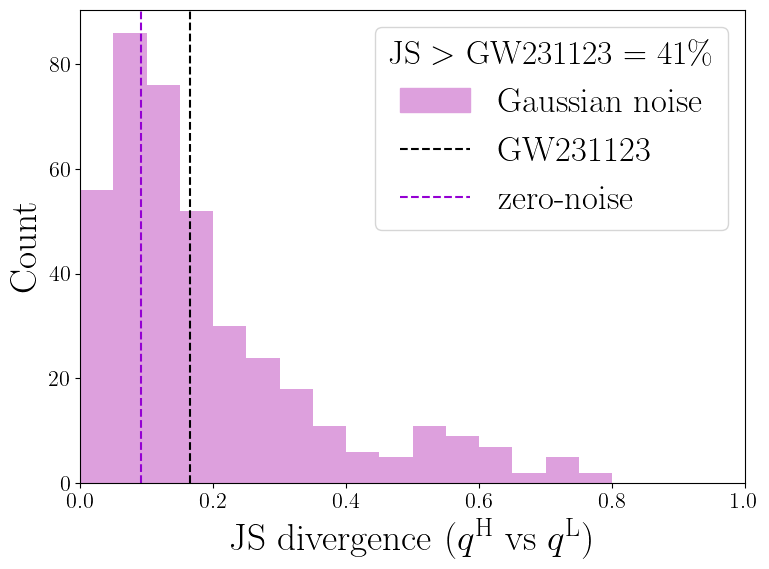

chi_eff: 208 / 400
[0.27513958]


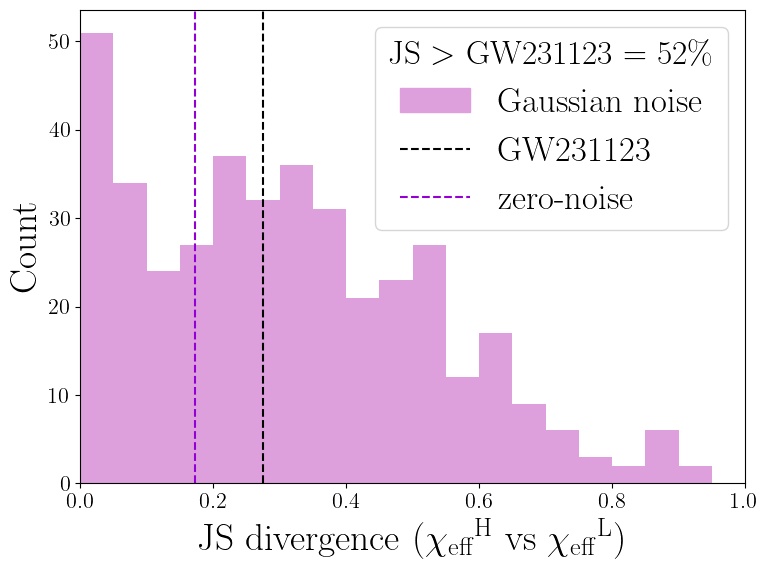

chi_p: 68 / 400
[0.23894637]


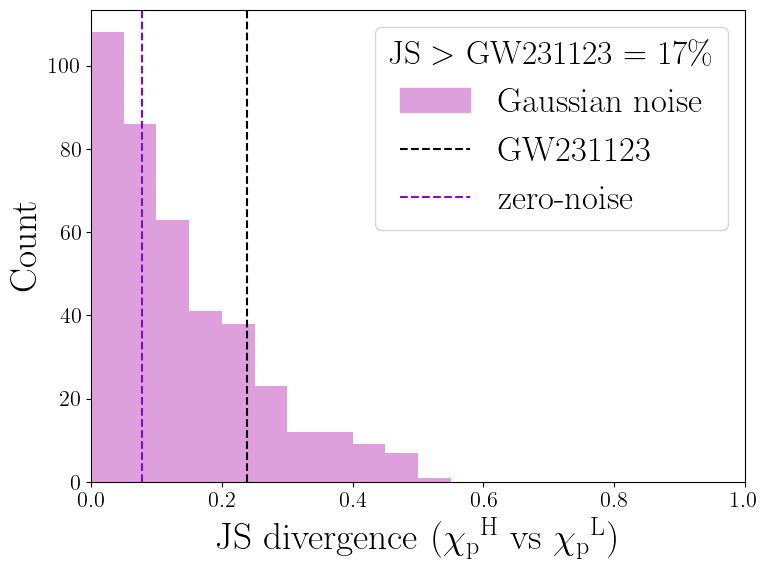

luminosity_distance: 64 / 400
[0.73472639]


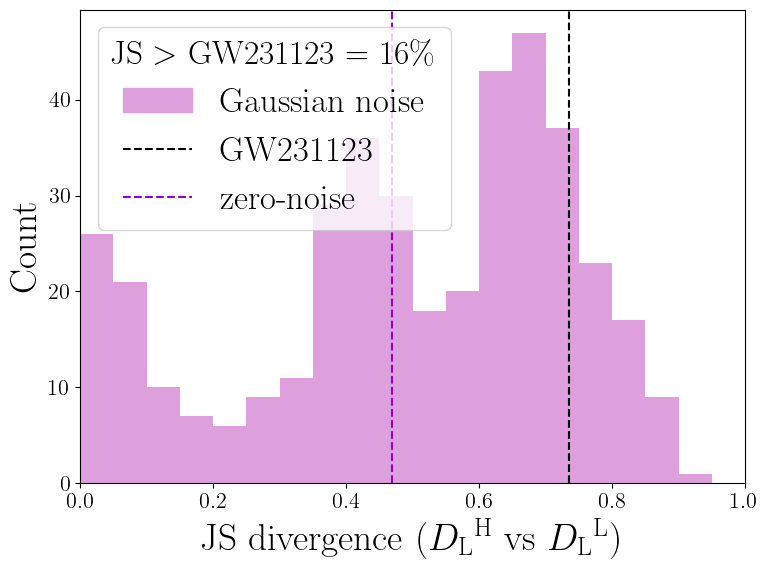

In [10]:
params_plot = ['total_mass','mass_ratio', 'chi_eff', 'chi_p','luminosity_distance']
param_to_str = {'total_mass':r'$(1+z)M$', 'mass_1':r'$m_1$', 'mass_2':r'$m_2$', 'chi_eff':r'$\chi_{\rm{eff}}$', 'chi_p':r'$\chi_{\rm{p}}$', 'mass_ratio':r'$q$', 'luminosity_distance':r'$D_{\rm{L}}$', 'iota':r'$\iota$', 'a_1':r'$\chi_1$', 'a_2':r'$\chi_2$', 'phase':r'$\varphi$', 'chirp_mass':r'$\mathcal{M}$', 'mass_1_source':r'$m_1^{\rm{source}}$', 'mass_2_source':r'$m_2^{\rm{source}}$'}

fractions = {}

for param in params_plot:
    fig, ax = plt.subplots(figsize=(8, 6))

    # Histogram
    n, bins, rects = ax.hist(
        divergences[param],color='plum', bins=20, range=(0,1),histtype='bar', label=f'{param_to_str[param]}' )

    ax.set_xlim(0, 1)
    if param=='total_mass':
        ax.set_xlabel(r" JS divergence   ($(1+z^{\mathrm{H}})M^\mathrm{H}$) vs $(1+z^\mathrm{L})M^\mathrm{L}$) ",fontsize=27)
    else:
        ax.set_xlabel(f" JS divergence   ({param_to_str[param]}$^{{\mathrm{{H}}}}$ vs {param_to_str[param]}$^{{\mathrm{{L}}}}$)",fontsize=27)
    ax.set_ylabel("Count", fontsize=27)

    legend_handles = []

    # Histogram label

    if param in divergences_event.keys():
        # Compute how many are higher than the event value
        higher = np.sum(divergences[param] > divergences_event[param])
        fractions[param] = f"{higher} / {len(divergences[param])}"

        # Add vertical line for GW231123 and zero-noise simulation
        line = ax.axvline(divergences_event[param], c='black', linestyle='--', label='GW231123')
        line0 = ax.axvline(divergences_zeronoise[param], c='darkviolet', linestyle='--', label='zero-noise')
        
        #legend
        fraction_patch2 = mpatches.Patch(color='plum', label=f'Gaussian noise')
        legend_handles.append(fraction_patch2)
        legend_handles.append(line)
        legend_handles.append(line0)

        print(f"{param}: {fractions[param]}")
        print(divergences_event[param])


    ax.legend(handles=legend_handles, fontsize=25, frameon=True,title=f'JS $>$ GW231123 = {np.round(100*higher/len(divergences[param]),0).astype(int)}$\%$',title_fontsize=24)#,loc='upper right')
    plt.tight_layout()
    plt.show()